## Modified from train_noise.ipynb

### Import some stuff

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
!pip install scikit-image
from skimage.util import random_noise
import seaborn as sns

mnist = tf.keras.datasets.mnist

def show(image):
    plt.figure(figsize=(10,10))
    new = image.copy()
    if image.shape == 3:                    # Switch R and B channels so it shows up as correctly as R,G,B, if image is 3-channel
        new[:,:,0] = image[:,:,2]
        new[:,:,2] = image[:,:,0]
    plt.imshow(new, cmap = "gray")        # Using plt.imshow because cv2.imshow causes MemoryError

     |████████████████████████████████| 13.3 MB 27.2 MB/s 
     |████████████████████████████████| 1.9 MB 76.9 MB/s 
     |████████████████████████████████| 178 kB 77.5 MB/s 
     |████████████████████████████████| 6.1 MB 70.2 MB/s 
     |████████████████████████████████| 3.3 MB 70.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Make a vanilla NN to train on MNIST. Note that y_train has been converted to one-hot-encoded vectors

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert y_train to length 10 vectors
y_train_new = []
for value in y_train:
    vector = [0]*10
    vector[value] = 1
    y_train_new.append(vector)
y_train_new = np.array(y_train_new)

# Model from Coursera Tensorflow Developers Course 1
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28), name='layer_1'),
  tf.keras.layers.Dense(512, activation=tf.nn.relu, name='layer_2'),
  tf.keras.layers.Dense(2, activation=tf.nn.relu, name='layer_3'),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='layer_final')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train_new, epochs=10, callbacks=[myCallback()]);

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.6732 - accuracy: 0.3639
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6834 - accuracy: 0.8099
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4721 - accuracy: 0.8421
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3892 - accuracy: 0.8512
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3265 - accuracy: 0.8718
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2295 - accuracy: 0.9538
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1648 - accuracy: 0.9652
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1342 - accuracy: 0.9704
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1061 - accuracy: 0.9763
Epoch 10/10
1875/

### Plot&nbsp;latent&nbsp;vectors&nbsp;in&nbsp;2D,&nbsp;color-coded&nbsp;by&nbsp;number

Note how latent vectors of pure noise overlap with clusters 0 and 3. This is why the model predicts 0 and 3 with high confidence for pure noise images.

100%|██████████| 2000/2000 [00:01<00:00, 1109.02it/s]
60000it [00:16, 3550.18it/s]
2000it [00:00, 3043.12it/s]


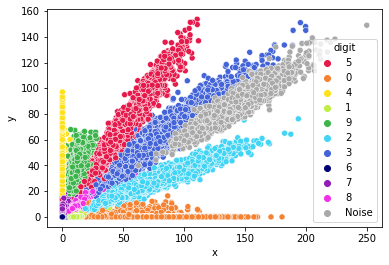

In [ ]:
# Extract penultimate layer with 2 dimensions
model_latent = tf.keras.Model(inputs=model.input,
                            outputs=model.get_layer('layer_3').output)

# Get latent vectors
latent_vecs = model_latent(x_train)

# Get latent vectors of 2000 pure noise images
latent_noise = []
for i in tqdm(range(2000)):
    img = np.random.rand(28,28)
    data = img.reshape(-1, img.shape[0], img.shape[1])
    latent_noise.append(model_latent(data))

# Create dataframe
df = []
for index, vec in tqdm(enumerate(latent_vecs)):
    df.append({'x': vec[0].numpy(), 'y': vec[1].numpy(), 'digit': y_train[index]})
for index, vec in tqdm(enumerate(latent_noise)):
    df.append({'x': vec[0][0].numpy(), 'y': vec[0][1].numpy(), 'digit': 'Noise'})

df = pd.DataFrame(df)

colors = sns.color_palette(['#e6194B','#f58231','#ffe119','#bfef45','#3cb44b','#42d4f4','#4363d8', '#000075', '#911eb4','#f032e6','#a9a9a9'])
sns.scatterplot(data=df, x="x", y="y", hue="digit", palette=colors);

### Check out model performance on test image

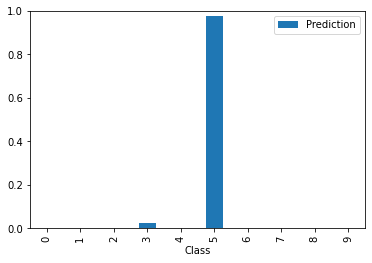

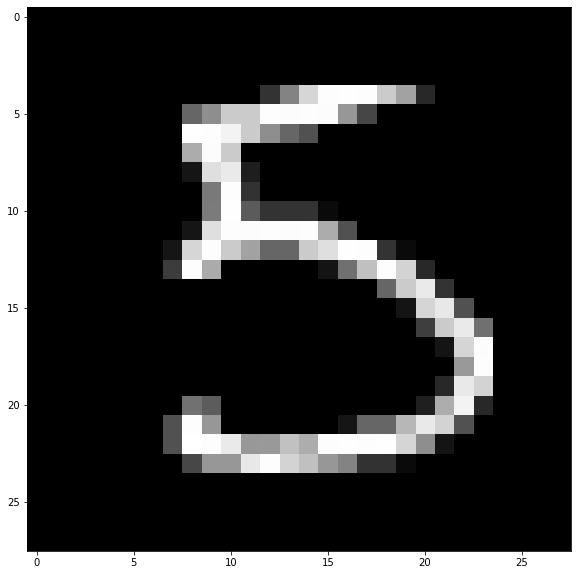

In [ ]:
# Select test image number
img_number = 15

# Model inference
img = x_test[img_number]
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Make a pure noise out-of-domain (OOD) image and see what the model thinks

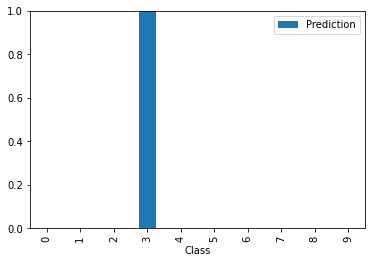

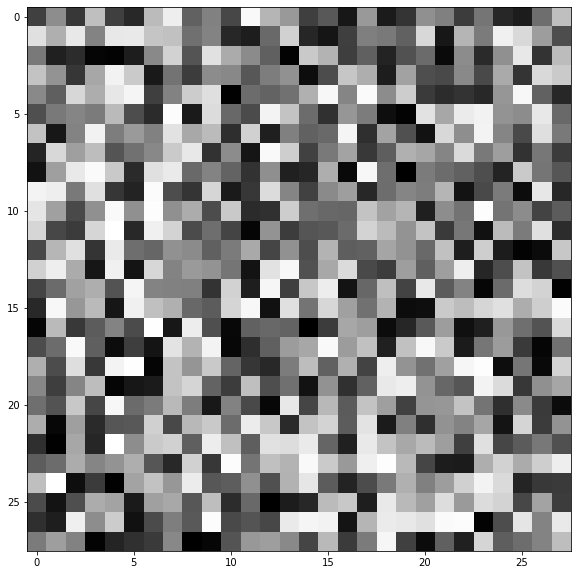

In [ ]:
# Create OOD image
ood = np.random.rand(28,28)
# ood = np.ones((28, 28))
# ood = np.zeros((28, 28))

# Model inference
img = ood
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### How does the model do on a noisy image?

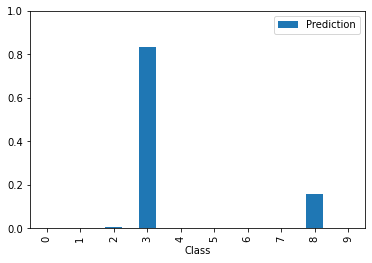

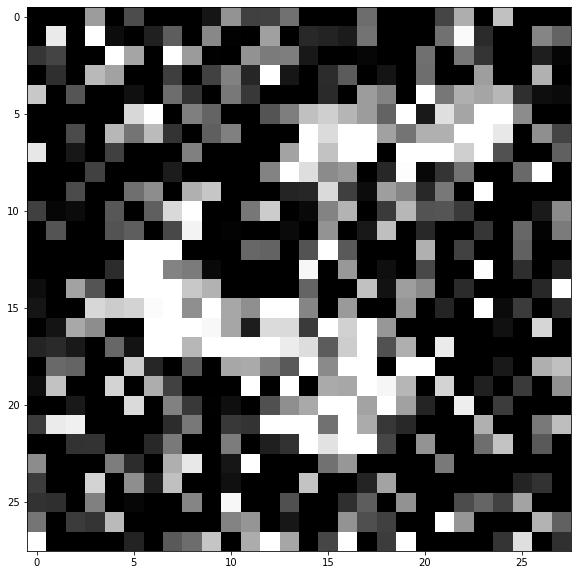

In [ ]:
# Select test image number
img_number = 8

# Model inference
img = x_test[img_number]

# Add some noise to image
img = random_noise(img, mode='gaussian', var=0.55**2)
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Now train again, but with a whole bunch of pure noise images with equal activation. Training accuracy tops out at ~0.5, probably because 1) half of the training set is pure noise and 2) the loss function probably doesn't know how to deal with pure noise images. The model does pretty well though (see tests below)

In [ ]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.49):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# Load training and testing data
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert y_train to length 10 vectors
y_train_new = []
for value in y_train:
    vector = [0]*10
    vector[value] = 1
    y_train_new.append(vector)

# Append 60000 pure noise images to x_train and y_train
x_train = list(x_train)
for i in tqdm(range(60000)):
    x_train.append(np.random.rand(28,28))
    y_train_new.append([0.1]*10)

# Shuffle x_train and y_train together
temp = list(zip(x_train, y_train_new))
np.random.shuffle(temp)
x_train, y_train_new = zip(*temp)

# Convert to np arrays
x_train, y_train_new = np.array(x_train), np.array(y_train_new)

model_new = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28), name='layer_1'),
  tf.keras.layers.Dense(512, activation=tf.nn.relu, name='layer_2'),
  tf.keras.layers.Dense(2, activation=tf.nn.relu, name='layer_3'),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='layer_final')
])

model_new.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_new.fit(x_train, y_train_new, epochs=20, callbacks=[myCallback()]);

100%|██████████| 60000/60000 [00:00<00:00, 80863.95it/s]
Epoch 1/20
3750/3750 [==============================] - 6s 1ms/step - loss: 2.3024 - accuracy: 0.0545
Epoch 2/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3024 - accuracy: 0.0557
Epoch 3/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3024 - accuracy: 0.0557
Epoch 4/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3023 - accuracy: 0.0567
Epoch 5/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3024 - accuracy: 0.0557
Epoch 6/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3023 - accuracy: 0.0563
Epoch 7/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3022 - accuracy: 0.0576
Epoch 8/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3022 - accuracy: 0.0564
Epoch 9/20
3750/3750 [==============================] - 5s 1ms/step - loss: 2.3024 - accuracy: 0.0556
Epoch 10/20
3750/3750 [==

### Plot&nbsp;latent&nbsp;vectors&nbsp;in&nbsp;2D,&nbsp;color-coded&nbsp;by&nbsp;number

See how pure noise images no longer overlap with a number cluster.

100%|██████████| 120000/120000 [00:00<00:00, 1067880.16it/s]
120000it [00:30, 3974.95it/s]


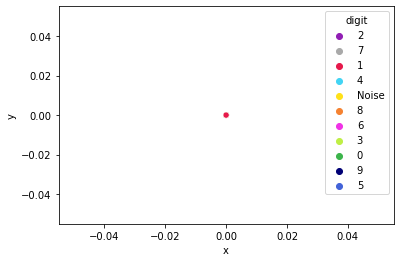

In [ ]:
# Extract penultimate layer with 2 dimensions
model_latent_new = tf.keras.Model(inputs=model_new.input,
                            outputs=model_new.get_layer('layer_3').output)

# Get latent vectors
latent_vecs_new = model_latent_new(x_train)

# Un-one-hot y_train_new
y_train_new_cats = []
for onehot_vec in tqdm(y_train_new):
    if onehot_vec[0] == 0.1:
        y_train_new_cats.append('Noise')
    else:
        y_train_new_cats.append(onehot_vec.argmax())

# Create dataframe
df_new = []
for index, vec in tqdm(enumerate(latent_vecs_new)):
    df_new.append({'x': vec[0].numpy(), 'y': vec[1].numpy(), 'digit': y_train_new_cats[index]})

df_new = pd.DataFrame(df_new)

sns.scatterplot(data=df_new, x="x", y="y", hue="digit", palette=sns.color_palette(['#911eb4','#a9a9a9','#e6194B','#42d4f4','#ffe119','#f58231','#f032e6','#bfef45','#3cb44b','#000075','#4363d8']));

### Like before, check out model performance on test image

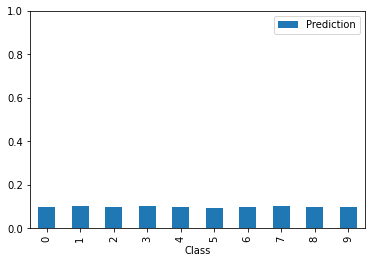

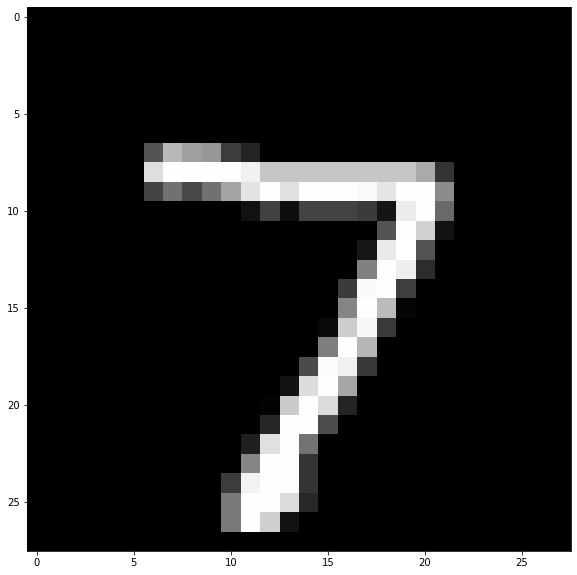

In [ ]:
# Select test image number
img_number = 0

# Model inference
img = x_test[img_number]
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### Like before, make OOD image and see what model thinks

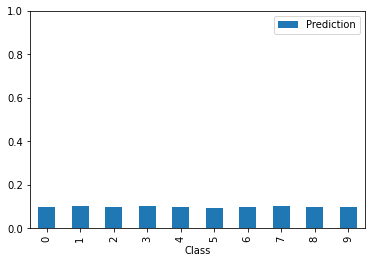

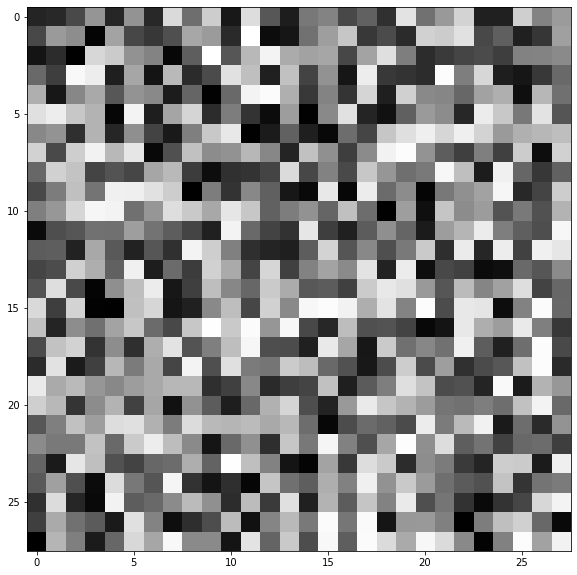

In [ ]:
# Create OOD image
ood = np.random.rand(28,28)
# ood = np.ones((28, 28))
# ood = np.zeros((28, 28))

# Model inference
img = ood
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})

df.plot.bar(x='Class', y='Prediction', ylim=(0,1))
show(img)

### How does the model do on a noisy image? Compared with previous model

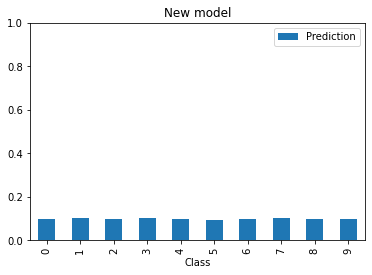

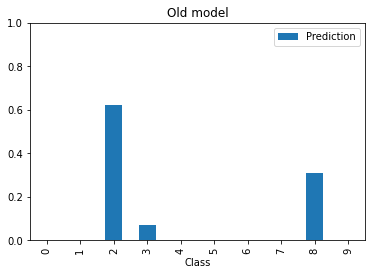

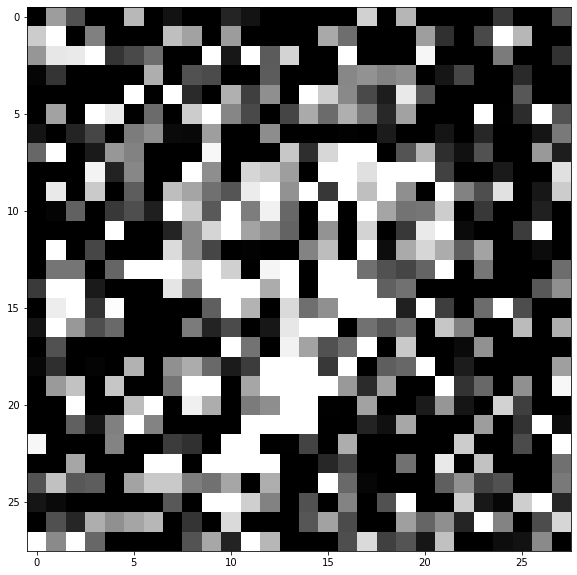

In [ ]:
# Select test image number
img_number = 9

# Model inference
img = x_test[img_number]

# Add some noise to image
img = random_noise(img, mode='gaussian', var=0.45)
data = img.reshape(-1, img.shape[0], img.shape[1])

prediction = model_new.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})
df.plot.bar(x='Class', y='Prediction', ylim=(0,1), title='New model')

prediction = model.predict(data)[0]
df = pd.DataFrame({'Class': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'Prediction': prediction})
df.plot.bar(x='Class', y='Prediction', ylim=(0,1), title = 'Old model')

show(img)

### Let's take confidence to be the height of the tallest bar. How is confidence affected by increasing noise?

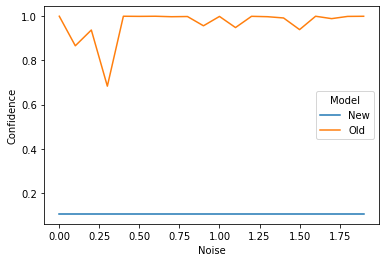

In [ ]:
# Select test image number
img_number = 1

# Model inference

new_model_confidences = []
old_model_confidences = []
noise_levels = []
img = x_test[img_number]

for noise in range(20):
    # Add some noise to image
    img_noise = random_noise(img, mode='gaussian', var=noise/10)
    data = img_noise.reshape(-1, img_noise.shape[0], img_noise.shape[1])

    new_prediction = model_new.predict(data)[0]
    new_model_confidences.append(new_prediction.max())

    old_prediction = model.predict(data)[0]
    old_model_confidences.append(old_prediction.max())

    noise_levels.append(noise/10)

df = pd.DataFrame({'Noise':noise_levels + noise_levels, 'Confidence':new_model_confidences + old_model_confidences, 'Model':['New']*len(new_model_confidences) + ['Old']*len(old_model_confidences)})
sns.lineplot(data = df, x='Noise', y='Confidence', hue = 'Model');


### We get a model that predicts actual numbers with high confidence and seems to deal with noisy images better. It also provides a more "uncertain" distribution for noisy images, and this could be potentially quantified as a measure of confidence.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f2dc94d7-bdba-4cca-bd94-69a815f4e540' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>